# Aufgabe 39
## Matrixfreier CG-Algorithmus
Es kann direkt das Verfahren wie im Skript verwendet werden, der Unterschied ist, dass nicht eine Matrix $A$ übergeben wird, sondern eine Funktion, die für gegebenes $x$ den Vektor $Ax$ bestimmt. 

In [1]:
from numpy import array

def cg_matrixfree(func,b,x0,tol):
    k=0
    tol=tol**2 # So spart man sich sowohl ||r||^2 als auch ||r|| ausrechnen zu müssen
    # Vorbereitung der ersten Iteration
    r=b-func(x0)
    d=r
    residual_norm=r@r # Schnelle Art ||r||^2 zu bestimmen
    # Iteration
    while residual_norm>tol:
        # Update der Näherung
        h=func(d) # Speicherung von Ad
        alpha=residual_norm/(d@h)
        # Update der Parameter
        x0=x0+alpha*d
        r=r-alpha*h
        residual_norm_new=r@r
        beta=residual_norm_new/residual_norm
        d=r+beta*d
        # Vorbereitung der nächsten Iteration
        k+=1
        residual_norm=residual_norm_new.copy()
    # Ausgabe
    return x0,k

Der Algorithmus wird an einem einfachen Beispiel getestet:

In [2]:
from numpy import arange,zeros
from numpy.linalg import norm

def testfunction(x):
    # Funktion, die die Multiplikation mit der Diagonalmatrix simuliert,
    # deren Diagonale die Form 1,2,3,...,n hat.
    d=arange(max(x.shape))+1
    return x*d


b=arange(10)+1 # rechte Seite, die Lösung ist entsprechend der Vektor 1,1,...,1
tol=1
x0=zeros(10)
x,k=cg_matrixfree(testfunction,b,x0,tol)
print('Ergebnis: {0},\nNorm des Residuum: {1},\nIterationen: {2}'.format(x,norm(testfunction(x)-b),k))

Ergebnis: [ 0.67014139  0.98098418  1.07141916  1.05074024  0.99864442  0.9652318
  0.97100558  1.00687205  1.03414062  0.98452376],
Norm des Residuum: 0.6352128293259851,
Iterationen: 4


Wird die (oben sehr groß) gewählte Toleranz verringert, lösen wir das Problem quasi exakt, braucen dann aber entsprend mehr Iterationen:

In [3]:
tol=1e-2
x,k=cg_matrixfree(testfunction,b,x0,tol)
print('Ergebnis: {0},\nNorm des Residuum: {1},\nIterationen: {2}'.format(x,norm(testfunction(x)-b),k))

Ergebnis: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.],
Norm des Residuum: 6.028010073543578e-15,
Iterationen: 10


## Matrixfreie 2d-Poissongleichung

In [4]:
from numpy import pad

def poisson2d(x):
    # Vektor in quadratische Matrix umwandeln 
    m=max(x.shape)
    n=int(m**(1/2))
    x=x.reshape((n,n))
    # zero padding
    h=pad(x,1,mode='constant')
    # Differenzen bilden
    y=4*x-h[:-2,1:-1]-h[2:,1:-1]-h[1:-1,:-2]-h[1:-1,2:]
    # Ausgabe als Vektor und Skalierung
    return y.ravel()*(n+1)**2

Erneut ein einfaches Testbeispiel, um sich von der Richtigkeit zu überzeugen. Ist $x$ ein Vektor, mit $x_i=c \forall i$, so sollten bei Anwendung der Poissonmatrix alle "inneren Einträge" (für $x$ als Matrix) verschwinden und nur am Rand der Wert $c n^2$ bzw. in den Ecken $2 c n^2$ über bleiben.

In [5]:
from numpy import ones

a=ones((9,9)).ravel() # d.h. n=10
# Anwendung der Matrix und Umformen in Matrix
b=poisson2d(a).reshape(9,9)
print(b)

[[ 200.  100.  100.  100.  100.  100.  100.  100.  200.]
 [ 100.    0.    0.    0.    0.    0.    0.    0.  100.]
 [ 100.    0.    0.    0.    0.    0.    0.    0.  100.]
 [ 100.    0.    0.    0.    0.    0.    0.    0.  100.]
 [ 100.    0.    0.    0.    0.    0.    0.    0.  100.]
 [ 100.    0.    0.    0.    0.    0.    0.    0.  100.]
 [ 100.    0.    0.    0.    0.    0.    0.    0.  100.]
 [ 100.    0.    0.    0.    0.    0.    0.    0.  100.]
 [ 200.  100.  100.  100.  100.  100.  100.  100.  200.]]


Um zu zeigen, dass sich auch noch größere Probleme als in der Aufgabenstellung in sinnvoller Zeit lösen lassen, hier ein weiteres Beispiel, bei dem die rechte Seite konstant $1$ ist mit einer Zeitmessung und $n=1000$.

Es wurden 1851 Iterationen in 285.2502770423889 Sekunden berechnet.


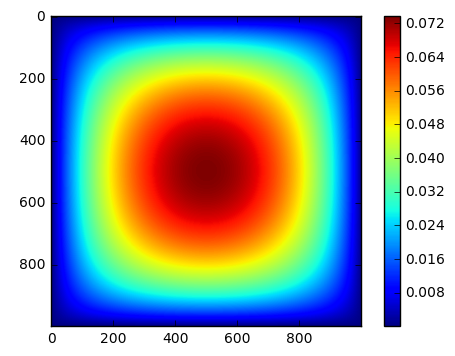

In [6]:
import time

n=1000-1
b=ones((n,n)).ravel()
x0=zeros((n,n)).ravel()
tol=1e-2/(n)

t0=time.time()
x,k=cg_matrixfree(poisson2d,b,x0,tol)
t=time.time()-t0
print('Es wurden {0} Iterationen in {1} Sekunden berechnet.'.format(k,t))

x=x.reshape((n,n))
import matplotlib.pyplot as plt

plt.imshow(x)
plt.colorbar()
plt.show()

Die Lösung $x$ hat in diesem Beispiel im Speicher eine Größe von ca. 10 MB (ein double Wert hat ungefähr die Größe 10 Byte und wir haben etwa $1000^2$ Einträge). Mit unserer (sehr naiven) Implementation von Matrizen bisher hätte die Poissonmatrix einen Speicherbedarf von etwa 10TB (10Byte und eine Größe von $1000^2 \times 1000^2$), vor ca. 10 Jahren wäre dies selbst für Supercomputer zu groß gewesen. Dies verdeutlicht noch einmal den Gewinn unseres Vorgehens.

Zurück zur eigentlichen Aufgabe:

In [7]:
from numpy import array,zeros,ogrid,broadcast_arrays

def rechte_seite(n):
    rechteSeite=zeros([n-1,n-1])
    x,y=ogrid[1/n:1-1/n:(n-1)*1j,1/n:1-1/n:(n-1)*1j]
    x, y = broadcast_arrays(x, y)
    rechteSeite[(1/8<=x) & (x<=1/4) & (1/8<=y) & (y<=5/8)]=2
    rechteSeite[(1/8<=y) & (y<=1/4) & (1/8<=x) & (x<=5/8)]=2
    z=(x-2/3)**2+(y-2/3)**2
    rechteSeite[z<=1/16]=-1
    return rechteSeite.ravel()

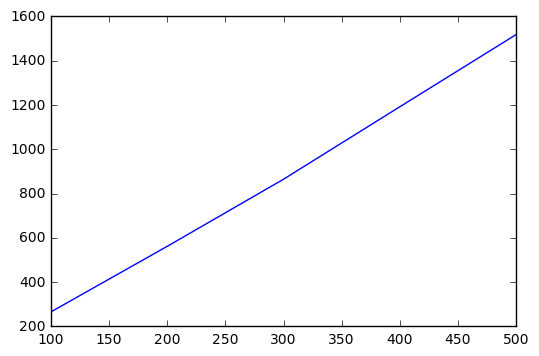

In [8]:
N=(arange(5)+1)*100
k_list=[]

for n in N:
    b=rechte_seite(n)
    x0=zeros((n-1,n-1)).ravel()
    tol=1e-2/(n)
    x,k=cg_matrixfree(poisson2d,b,x0,tol)
    k_list.append(k)

import matplotlib.pyplot as plt

plt.plot(N,k_list)
plt.show()

Wir beobachten eine linear mit der Größe des Problems steigende Anzahl an Iterationen.

Zum Abschluss plotten wir die zu letzt berechnete Lösung.

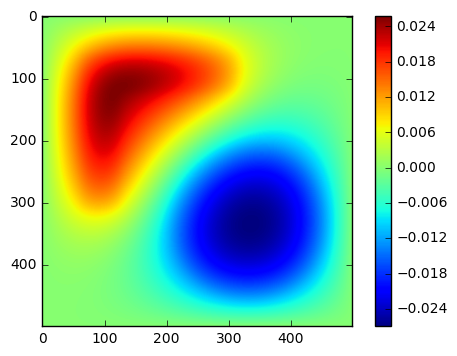

In [9]:
n=max(N)-1
x=x.reshape((n,n))
plt.imshow(x)
plt.colorbar()
plt.show()